In [4]:
import pandas as pd

In [2]:
df = pd.read_parquet('../input/m5-forecasting-parquet-and-aggregations/daily_sales_items_top105.parquet')
df = df.loc[df.date>='2015-01-01']
df['weekday'] = df['date'].dt.weekday
df.drop(columns=['d'], inplace=True)
id_columns = [c for c in df.columns.values if 'id' in c]
for c in id_columns:
    df[c] = df[c].astype('category')
df.sample(5)

id          item_id      dept_id  \
51766454    HOBBIES_2_117_WI_2_evaluation    HOBBIES_2_117    HOBBIES_2   
6788914       FOODS_2_013_TX_3_evaluation      FOODS_2_013      FOODS_2   
44248326  HOUSEHOLD_2_142_CA_3_evaluation  HOUSEHOLD_2_142  HOUSEHOLD_2   
26109170  HOUSEHOLD_1_019_CA_4_evaluation  HOUSEHOLD_1_019  HOUSEHOLD_1   
27619682      FOODS_2_013_WI_2_evaluation      FOODS_2_013      FOODS_2   

             cat_id store_id state_id  value       date  weekday  
51766454    HOBBIES     WI_2       WI      0 2015-02-15        6  
6788914       FOODS     TX_3       TX      7 2015-11-21        5  
44248326  HOUSEHOLD     CA_3       CA      0 2015-06-14        6  
26109170  HOUSEHOLD     CA_4       CA      4 2015-06-30        1  
27619682      FOODS     WI_2       WI     30 2016-04-21        3

# 1. Aufgabe - direkte ML-Modelle

Erstelle Modelle für die Vorhersage der nächsten 7 Tagen. Erstelle dafür für jeden Vorhersageschritt (morgen, übermorgen, ...) ein eigenes Modell. Benutze einen gleitenden Durchschnitt über die letzten 7 Tagen und erstelle ein Trend-Feature wie im COVID-19 Beispiel ebenfalls mit einer Differenz von 7 Tagen. Nutze den Wochentag als Feature aber nicht das Datum. Plotte die Vorhersagen je Kategorie.

## Feature Engineering

In [3]:
df.sort_values(['date'], inplace=True)

# Vervollständige die Zeile mit einem rollenden Durchschnitt für 7 Tage
# df['value_trend'] = df.groupby(['id'])['value'] TODO...

# Berechne die Differenz von 7 Tagen
# df['value_trend_slope'] = df.groupby(['id'])['value_trend']
df.sample(5)

id          item_id      dept_id  \
37710318    HOBBIES_1_295_WI_2_evaluation    HOBBIES_1_295    HOBBIES_1   
47671909  HOUSEHOLD_1_234_TX_2_evaluation  HOUSEHOLD_1_234  HOUSEHOLD_1   
51188128  HOUSEHOLD_2_421_WI_2_evaluation  HOUSEHOLD_2_421  HOUSEHOLD_2   
29229557      FOODS_2_016_TX_3_evaluation      FOODS_2_016      FOODS_2   
4767657       FOODS_2_244_CA_4_evaluation      FOODS_2_244      FOODS_2   

             cat_id store_id state_id  value       date  weekday  value_trend  \
37710318    HOBBIES     WI_2       WI      2 2015-03-07        5     0.857143   
47671909  HOUSEHOLD     TX_2       TX      0 2015-08-23        6     0.000000   
51188128  HOUSEHOLD     WI_2       WI      0 2016-01-28        3     0.714286   
29229557      FOODS     TX_3       TX      0 2015-07-21        1     0.000000   
4767657       FOODS     CA_4       CA      4 2015-09-19        5     5.285714   

          value_trend_slope  
37710318          -1.857143  
47671909          -1.285714  
51188128           0.428571  
29229557           0.000000  
4767657            0.285714

## Training (7 direkte Modelle)

In [ ]:
%%time

from sklearn.ensemble import RandomForestRegressor

horizon = 7

# Features für das Training
X = # TODO Entferne alle NANs
X.drop(columns=['id', 'date'], inplace=True) # ID, Jahr und Monat nutzen wir nicht als Feature
X['dept_id'] = X['dept_id'].cat.codes # RandomForest kann nur numerische Features handhaben => Kategorien konvertieren
X['cat_id'] = X['cat_id'].cat.codes # RandomForest kann nur numerische Features handhaben => Kategorien konvertieren
X['store_id'] = X['store_id'].cat.codes # RandomForest kann nur numerische Features handhaben => Kategorien konvertieren
X['state_id'] = X['state_id'].cat.codes # RandomForest kann nur numerische Features handhaben => Kategorien konvertieren
X['item_id'] = X['item_id'].cat.codes # RandomForest kann nur numerische Features handhaben => Kategorien konvertieren
X = X.astype('float32') # der Random Forest von RAPIDS mag nur Floats

# Trainieren
models = [] # Liste mit Modellen je Vorhersagehorizont
# TODO Iteration über alle Horizonte. 1 Modell je Horizont (1 Zeile als Schleife)
    
    # TODO: Vervollständigen der Zielvariablen. Gruppieren nach store_id, dept_id, item_id und shiften abhängig vom Horizont
    y = # TODO
    
    model = # TODO: Modell initialisieren
    model.fit(X[~y.isnull()], y.dropna()) # nur mit Beispielen trainieren, für die es einen Zielwert gibt
    models.append(model)

## Vorhersage (7 direkte Modelle)

In [ ]:
forecast_date = df['date'].max()

# Features für die Vorhersage
Xf = df[df['date']==forecast_date].copy()
Xf.drop(columns=['id', 'date'], inplace=True) # ID, Jahr und Monat nutzen wir nicht als Feature

Xf['dept_id'] = Xf['dept_id'].cat.codes # RandomForest kann nur numerische Features handhaben => Kategorien konvertieren
Xf['cat_id'] = Xf['cat_id'].cat.codes # RandomForest kann nur numerische Features handhaben => Kategorien konvertieren
Xf['store_id'] = Xf['store_id'].cat.codes # RandomForest kann nur numerische Features handhaben => Kategorien konvertieren
Xf['state_id'] = Xf['state_id'].cat.codes # RandomForest kann nur numerische Features handhaben => Kategorien konvertieren
Xf['item_id'] = Xf['item_id'].cat.codes # RandomForest kann nur numerische Features handhaben => Kategorien konvertieren
Xf = Xf.astype('float32')

result = pd.DataFrame() # wird alle Vorhersagen mit Country/Region, Datum und Wert enthalten
for h in range(0, horizon):
    # TODO: Benutze das Model für die Vorhersage mit der predict Funktion
    prediction = #
    
    tmp = Xf[['dept_id', 'cat_id', 'store_id', 'state_id', 'item_id']].assign(forecast_value = prediction)
    tmp['date'] = forecast_date + pd.DateOffset(days=h+1)
    result = result.append(tmp)
    
result['dept_id'] = df['dept_id'].cat.categories[result['dept_id'].astype('int')] # Werte der Kategorien zurückkonvertieren
result['cat_id'] = df['cat_id'].cat.categories[result['cat_id'].astype('int')] # Werte der Kategorien zurückkonvertieren
result['store_id'] = df['store_id'].cat.categories[result['store_id'].astype('int')] # Werte der Kategorien zurückkonvertieren
result['state_id'] = df['state_id'].cat.categories[result['state_id'].astype('int')] # Werte der Kategorien zurückkonvertieren
result['item_id'] = df['item_id'].cat.categories[result['item_id'].astype('int')] # Werte der Kategorien zurückkonvertieren
result = result.append(df.loc[df['date'] <= forecast_date][['dept_id', 'cat_id', 'store_id', 'state_id', 'item_id', 'date', 'value']]) # Ist-Werte zum Ergebnis hinzufügen

## Plot der Vorhersagen je Kategorie

In [ ]:
facet_column = # TODO Kategoriespalte selektieren

fig = px.line(result.
                  groupby(# TODO: Nach Kategorie und Datum gruppieren).
                  agg({'value': sum, 'forecast_value': sum}).
                  reset_index(),
              x='date', y=['value', 'forecast_value'], facet_row=facet_column,
              title='Titel')
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
fig.update_yaxes(matches=None)
fig.show()

# Musterlösung: 1. Aufgabe - direkte Modelle

## Feature Engineering

In [ ]:
df.sort_values(['date'], inplace=True)
df['value_trend'] = df.groupby(['id'])['value'].rolling(window=7).mean().reset_index(level=0, drop=True)
df['value_trend_slope'] = df.groupby(['id'])['value_trend'].diff(7)
df.sample(5)

## Training (7 direkte Modelle)

In [6]:
%%time

from sklearn.ensemble import RandomForestRegressor

horizon = 7

# Features für das Training
X = df.dropna().copy() # nur mit Beispielen (Zeilen) trainieren, für die alle Features einen Wert haben
X.drop(columns=['id', 'date'], inplace=True) # ID, Jahr und Monat nutzen wir nicht als Feature
X['dept_id'] = X['dept_id'].cat.codes # RandomForest kann nur numerische Features handhaben => Kategorien konvertieren
X['cat_id'] = X['cat_id'].cat.codes # RandomForest kann nur numerische Features handhaben => Kategorien konvertieren
X['store_id'] = X['store_id'].cat.codes # RandomForest kann nur numerische Features handhaben => Kategorien konvertieren
X['state_id'] = X['state_id'].cat.codes # RandomForest kann nur numerische Features handhaben => Kategorien konvertieren
X['item_id'] = X['item_id'].cat.codes # RandomForest kann nur numerische Features handhaben => Kategorien konvertieren
X = X.astype('float32') # der Random Forest von RAPIDS mag nur Floats

# Trainieren
models = [] # Liste mit Modellen je Vorhersagehorizont
for h in range(1, horizon+1):
    y = X.groupby(['store_id', 'dept_id', 'item_id'])['value'].shift(-h) # Zielvariable aus der verschobenen Zeitreihe ableiten
    
    model = RandomForestRegressor(max_depth=8, n_estimators=100)
    model.fit(X[~y.isnull()], y.dropna()) # nur mit Beispielen trainieren, für die es einen Zielwert gibt
    models.append(model)

CPU times: user 12.8 s, sys: 24.9 ms, total: 12.8 s
Wall time: 12.8 s


## Vorhersage (7 direkte Modelle)

In [8]:
forecast_date = df['date'].max()

# Features für die Vorhersage
Xf = df[df['date']==forecast_date].copy()
Xf.drop(columns=['id', 'date'], inplace=True) # ID, Jahr und Monat nutzen wir nicht als Feature

Xf['dept_id'] = Xf['dept_id'].cat.codes # RandomForest kann nur numerische Features handhaben => Kategorien konvertieren
Xf['cat_id'] = Xf['cat_id'].cat.codes # RandomForest kann nur numerische Features handhaben => Kategorien konvertieren
Xf['store_id'] = Xf['store_id'].cat.codes # RandomForest kann nur numerische Features handhaben => Kategorien konvertieren
Xf['state_id'] = Xf['state_id'].cat.codes # RandomForest kann nur numerische Features handhaben => Kategorien konvertieren
Xf['item_id'] = Xf['item_id'].cat.codes # RandomForest kann nur numerische Features handhaben => Kategorien konvertieren
Xf = Xf.astype('float32')

result = pd.DataFrame() # wird alle Vorhersagen mit Country/Region, Datum und Wert enthalten
for h in range(0, horizon):
    prediction = models[h].predict(Xf)
    tmp = Xf[['dept_id', 'cat_id', 'store_id', 'state_id', 'item_id']].assign(forecast_value = prediction)
    tmp['date'] = forecast_date + pd.DateOffset(days=h+1)
    result = result.append(tmp)
    
result['dept_id'] = df['dept_id'].cat.categories[result['dept_id'].astype('int')] # Werte der Kategorien zurückkonvertieren
result['cat_id'] = df['cat_id'].cat.categories[result['cat_id'].astype('int')] # Werte der Kategorien zurückkonvertieren
result['store_id'] = df['store_id'].cat.categories[result['store_id'].astype('int')] # Werte der Kategorien zurückkonvertieren
result['state_id'] = df['state_id'].cat.categories[result['state_id'].astype('int')] # Werte der Kategorien zurückkonvertieren
result['item_id'] = df['item_id'].cat.categories[result['item_id'].astype('int')] # Werte der Kategorien zurückkonvertieren
result = result.append(df.loc[df['date'] <= forecast_date][['dept_id', 'cat_id', 'store_id', 'state_id', 'item_id', 'date', 'value']]) # Ist-Werte zum Ergebnis hinzufügen

## Plot der Vorhersagen je Kategorie

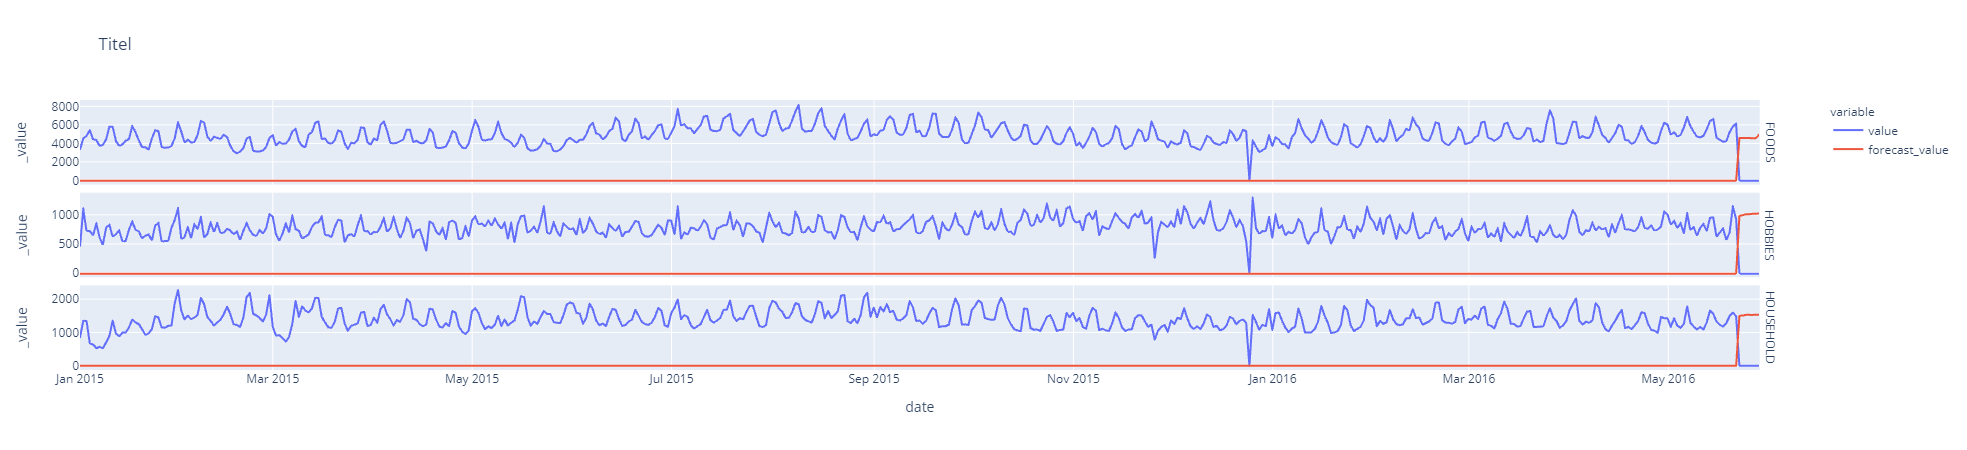

In [9]:
facet_column = 'cat_id' # probehalber auch mal mit state_id ausprobieren

fig = px.line(result.
                  groupby([facet_column, 'date']).
                  agg({'value': sum, 'forecast_value': sum}).
                  reset_index(),
              x='date', y=['value', 'forecast_value'], facet_row=facet_column,
              title='Titel')
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
fig.update_yaxes(matches=None)
fig.show()